In [5]:
import numpy as np
import cv2
import os
from datetime import datetime
from collections import defaultdict

import robosuite
from robosuite.custom_utils.assembly_utils import *


# Load config file
config_path = "../configs/thesis_exp_configs.json"
configs = read_file(config_path)

# Make a directory to save files
save_dir = os.path.join(configs["save_root"], f'captured_images_{datetime.today().strftime("%Y%m%d-%H%M%S")}_thesis_{configs["exp_id"]}_{env_config["env_name"]}')
# if not configs["llm"]["model_config"]["top_p"] :    # if setting of top_p is null
#     save_dir += "_topp1"    # top_p=1.0 as default
save_dir += f'_topp{format(configs["llm"]["model_config"]["top_p"], ".0e").replace("0e", "e")}'  # ex) "0.2" -> "2e-1"
os.mkdir(save_dir)

# Save the current files
os.system(f"cp ../custom_utils/assembly_llm.py {os.path.join(save_dir, 'assembly_llm.py')}")
os.system(f"cp {config_path} {os.path.join(save_dir, os.path.basename(config_path))}")

# mode = configs["relation"]["dist_mode"]
mode = False
if mode is False:    # When applying spatial relation primitives
    system_prompt = configs["relation"]["prim_prompt_files"]["system_prompt"]
    os.system(f"cp {system_prompt} {os.path.join(save_dir, os.path.basename(system_prompt))}")

    examples_prompt = configs["relation"]["prim_prompt_files"]["examples_prompt"]
    os.system(f"cp {examples_prompt} {os.path.join(save_dir, os.path.basename(examples_prompt))}")
else:    # When applying 3D distance relationships
    dist_examples_prompt = configs["relation"]["dist_prompt_files"]["examples_prompt"]
    os.system(f"cp {dist_examples_prompt} {os.path.join(save_dir, os.path.basename(dist_examples_prompt))}")

    dist_example_rgb_paths = configs["relation"]["dist_prompt_files"]["example_rgb_paths"]
    if dist_example_rgb_paths:
        os.system(f"cp {dist_example_rgb_paths} {os.path.join(save_dir, os.path.basename(dist_example_rgb_paths))}")
        
    dist_example_depth_paths = configs["relation"]["dist_prompt_files"]["example_depth_paths"]
    if dist_example_depth_paths:
        os.system(f"cp {dist_example_depth_paths} {os.path.join(save_dir, os.path.basename(dist_example_depth_paths))}")
        
    dist_example_seg_paths = configs["relation"]["dist_prompt_files"]["example_seg_paths"]
    if dist_example_seg_paths:
        os.system(f"cp {dist_example_seg_paths} {os.path.join(save_dir, os.path.basename(dist_example_seg_paths))}")

ModuleNotFoundError: No module named 'robosuite'

### **Test 'Sandwich'**

In [ ]:
from robosuite.custom_utils.assembly_llm import AssemblyLLM, AssemblyLLMOpenAI
from robosuite.custom_utils.assembly_spatial_graph import AssemblySpatialGraph
from robosuite.custom_utils.assembly_planner import AssemblyPlanner


# Set up modules of LLM and Graph
# llm = AssemblyLLM(configs)
# llm = AssemblyLLMOpenAI(configs)
llm = AssemblyLLMOpenAI(configs, distance_relations=mode)

# Get llm response
# detected_blocks, instructions = llm(log_res_path=os.path.join(save_dir, "log_llm_res.txt"))    # returns detected_blocks and assembly_structure
content = llm(log_res_path=os.path.join(save_dir, "log_llm_res.txt"))    # returns 'content' of response from LLM
detected_blocks = content["detected_blocks"]

if "assembly_structure" in content.keys():
    instructions = content["assembly_structure"]
    print("* * *")
    print("Instructions: ", instructions)

else:
    print(content.keys())

### **For generating the image from a response**

[assembly_spatial_graph.py] Generating a spatial graph for the instructions
Spatial graph:  defaultdict(<class 'list'>, {'block0': [('base', 'none')], 'block2': [('right', 'block0')], 'block4': [('right', 'block2')], 'block5': [('top', 'block2', 'block4')], 'block1': [('top', 'block0', 'block2')], 'block3': [('top', 'block1', 'block5')]})
[assembly_spatial_graph.py] Generating the assembly order
Assembly order:  ['block0', 'block2', 'block4', 'block5', 'block1', 'block3']
/home/juhee/thesis/figures/res_pyramid_openaiapi_gpt4o_0329_2025-03-29_16-08-02.png


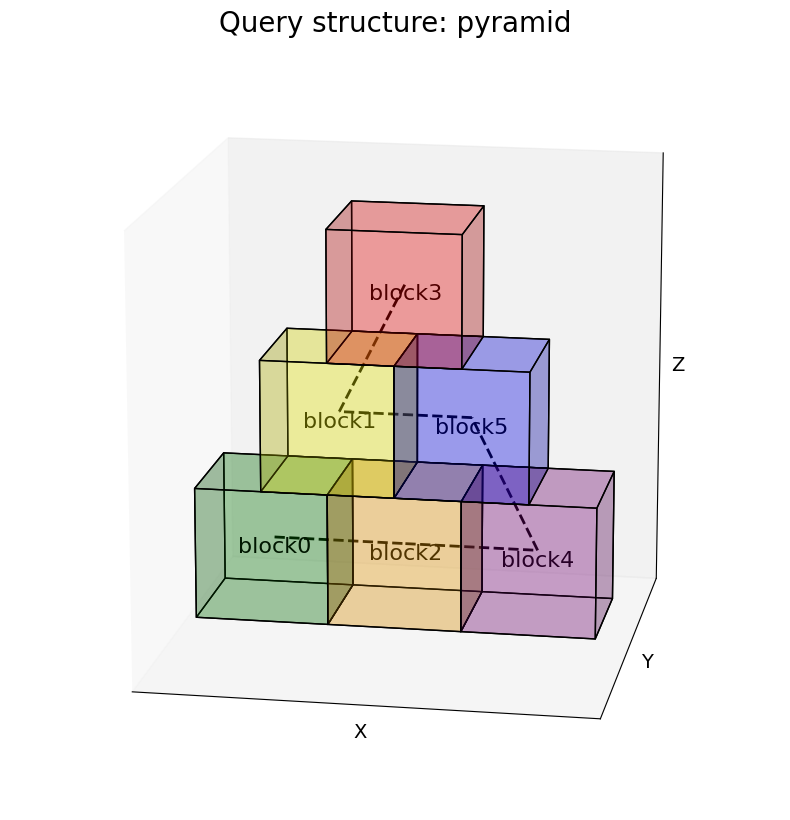

In [1]:
import os
from robosuite.custom_utils.assembly_spatial_graph import AssemblySpatialGraph
from robosuite.custom_utils.assembly_utils import compute_positions_from_instructions, visualize_structure

content = {
  "input_structure": "pyramid",    # Query: "pyramid in 2D plane"
  "block_length": 0.04,
  "detected_blocks": [
    {"id": "block0", "color": "green"},
    {"id": "block1", "color": "yellow"},
    {"id": "block2", "color": "orange"},
    {"id": "block3", "color": "red"},
    {"id": "block4", "color": "purple"},
    {"id": "block5", "color": "blue"}
  ],
  "assembly_structure": [
    "block0 is on the table.",
    "block2 is right of block0.",
    "block4 is right of block2.",
    "block5 is above block2 and block4.",
    "block1 is above block0 and block2.",
    "block3 is above block1 and block5."
  ]  
}
log_date = "2025-03-29_16-08-02"
file_name = "openaiapi_gpt4o_0329"

instructions = content["assembly_structure"]
g = AssemblySpatialGraph()
spatial_graph, assembly_order = g(instructions)
new_block_positions = compute_positions_from_instructions(spatial_graph, assembly_order)
block_matches = {b["id"]: "cube"+c for b, c in zip(content["detected_blocks"], ["A", "B", "C", "D", "E", "F"])}
block_colors = {b["id"]: b["color"] for b in content["detected_blocks"]}

save_dir = "/home/juhee/thesis/figures"
save_file_path = os.path.join(save_dir, f"res_{content['input_structure']}_{file_name}_{log_date}.png")
visualize_structure(
    assembly_order,
    new_block_positions,
    block_matches,
    block_colors,
    content['input_structure'],
    save_file_path,
    alpha=0.2,
    zoom=1.0)
print(save_file_path)